# Linear Modeling

## Setup

In [1]:
library(tidyverse)
library(modelr)
library(tidyr)
library(alr3)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats
Loading required package: car

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some


Attaching package: ‘alr3’

The following object is masked from ‘package:modelr’:

    heights



In [2]:
options(repr.plot.height=4.5)

## Single Regression

Let's work with the `heights` data.

What does the data look like?

In [3]:
head(heights)

Mheight,Dheight
59.7,55.1
58.2,56.5
60.6,56.0
60.7,56.8
61.8,56.0
55.5,57.9


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


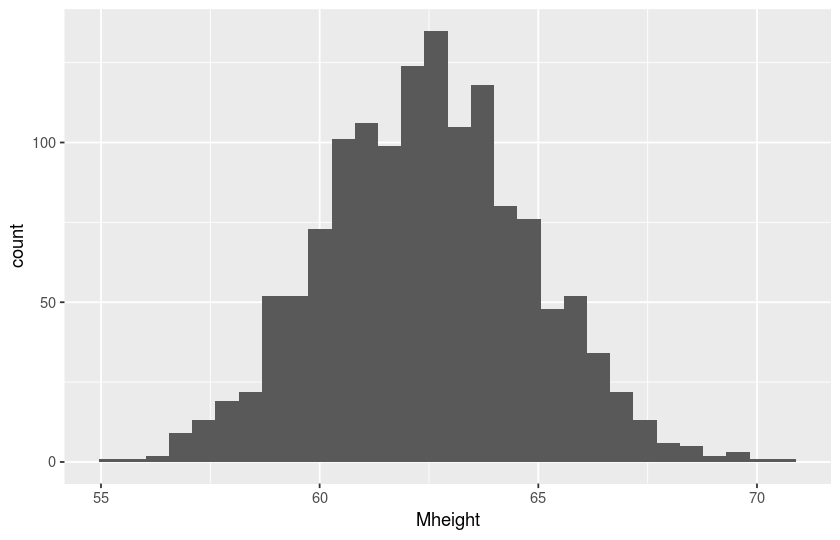

In [4]:
ggplot(heights) +
    aes(x=Mheight) +
    geom_histogram()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


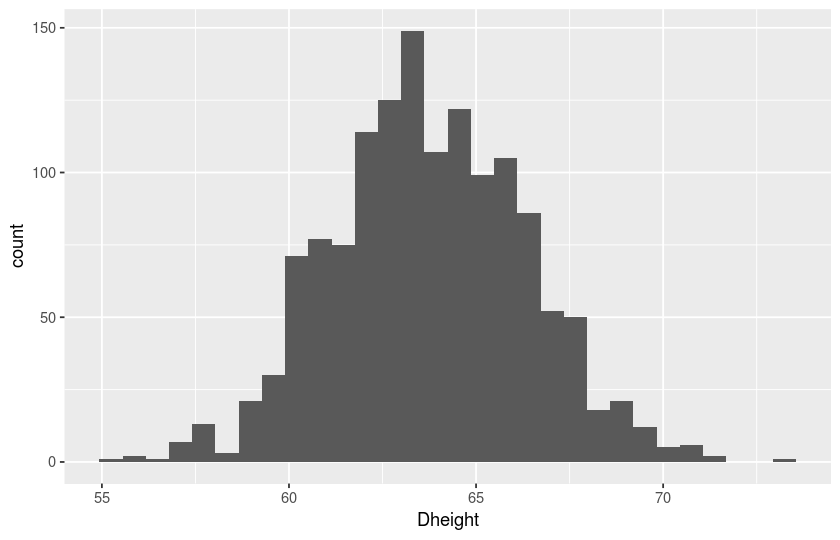

In [5]:
ggplot(heights) +
    aes(x=Dheight) +
    geom_histogram()

What if we want to view these side by side?

1. Gather values into 'tall' format
2. Plot with a 'facet'

In [6]:
tall_heights = gather(heights, "var", "height")
head(tall_heights)

var,height
Mheight,59.7
Mheight,58.2
Mheight,60.6
Mheight,60.7
Mheight,61.8
Mheight,55.5


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


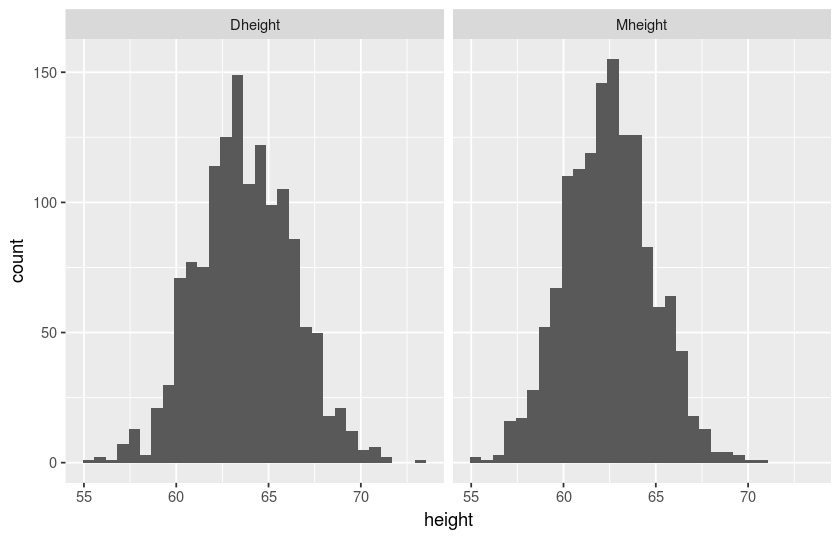

In [7]:
ggplot(tall_heights) +
    aes(x=height) +
    geom_histogram() +
    facet_wrap(~ var)

But we don't see relationships yet - let's plot the two variables together.

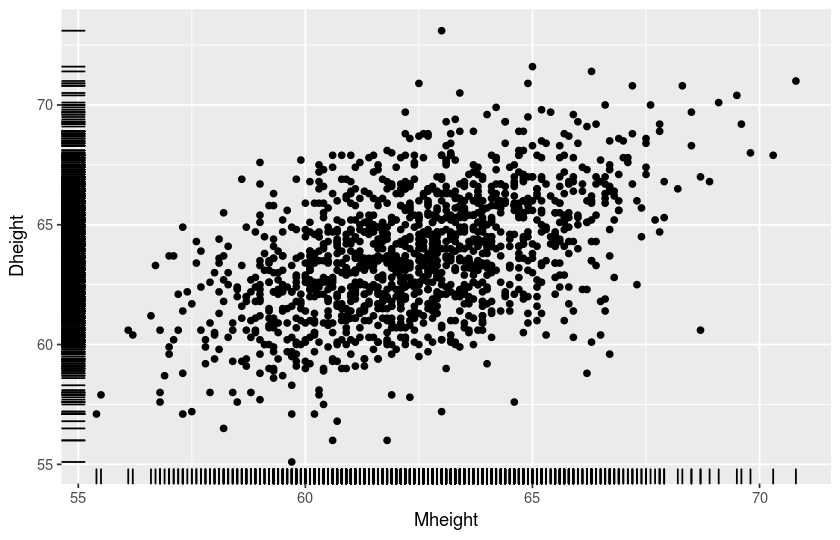

In [9]:
ggplot(heights) +
    aes(x=Mheight, y=Dheight) +
    geom_point() +
    geom_rug()

This looks like a line might fit. Let's try it!

The `lm` function lets us fit a line.

In [10]:
height_model = lm(Dheight ~ Mheight, data=heights)
summary(height_model)


Call:
lm(formula = Dheight ~ Mheight, data = heights)

Residuals:
   Min     1Q Median     3Q    Max 
-7.397 -1.529  0.036  1.492  9.053 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.91744    1.62247   18.44   <2e-16 ***
Mheight      0.54175    0.02596   20.87   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.266 on 1373 degrees of freedom
Multiple R-squared:  0.2408,	Adjusted R-squared:  0.2402 
F-statistic: 435.5 on 1 and 1373 DF,  p-value: < 2.2e-16


'Goodness of Fit' statistics:

- $R^2 = 0.24$ means 24% of variance in daughter height explained by model. Whether that's good is domain-specific.
- $p$ small; model is worth considering.

Let's plot the model!

In [11]:
heights_with_preds = heights %>% add_predictions(height_model)
head(heights_with_preds)

Mheight,Dheight,pred
59.7,55.1,62.25973
58.2,56.5,61.44711
60.6,56.0,62.74731
60.7,56.8,62.80148
61.8,56.0,63.39740
55.5,57.9,59.98440


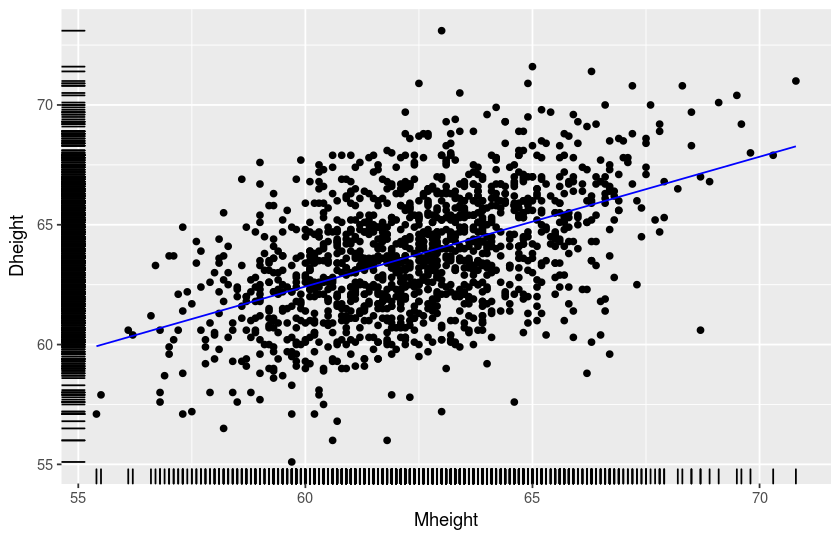

In [13]:
ggplot(heights_with_preds) +
    aes(x=Mheight, y=Dheight) +
    geom_point() +
    geom_line(mapping=aes(y=pred), color="blue") +
    geom_rug()

## Assumption Checking

- error (residual) is independent and normally distributed
- data points are independent

To test error distribution, we plot error (residual) by fitted (predicted) value.

In [14]:
heights_with_mod = heights %>%
    add_predictions(height_model) %>%
    add_residuals(height_model)
head(heights_with_mod)

Mheight,Dheight,pred,resid
59.7,55.1,62.25973,-7.159733
58.2,56.5,61.44711,-4.947113
60.6,56.0,62.74731,-6.747306
60.7,56.8,62.80148,-6.001480
61.8,56.0,63.39740,-7.397402
55.5,57.9,59.98440,-2.084396


`geom_smooth()` using method = 'gam'


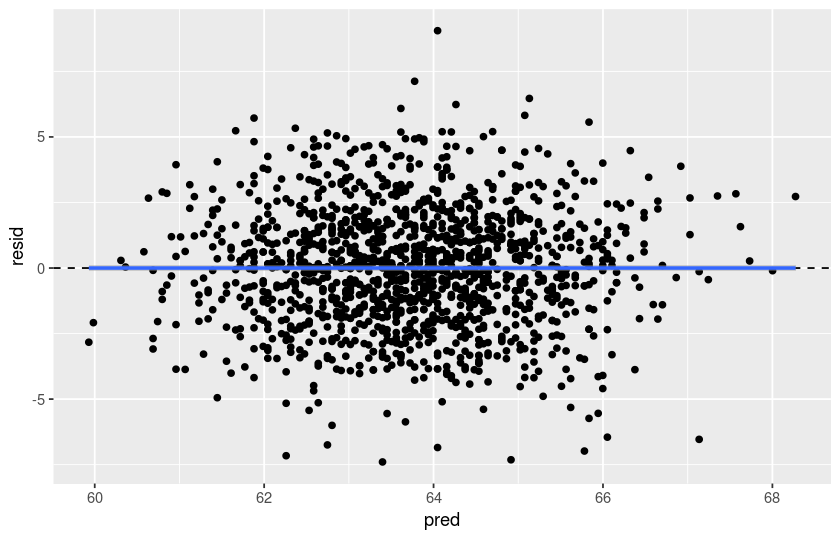

In [17]:
ggplot(heights_with_mod) +
    aes(x=pred, y=resid) +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_point() + geom_smooth()

No observable pattern, we think residuals are indepent of predicted values so the model assumption seems to hold.

If it doesn't, then goodness-of-fit statistics and inference are invalid.

Let's quick look at residual vs. actual:

`geom_smooth()` using method = 'gam'


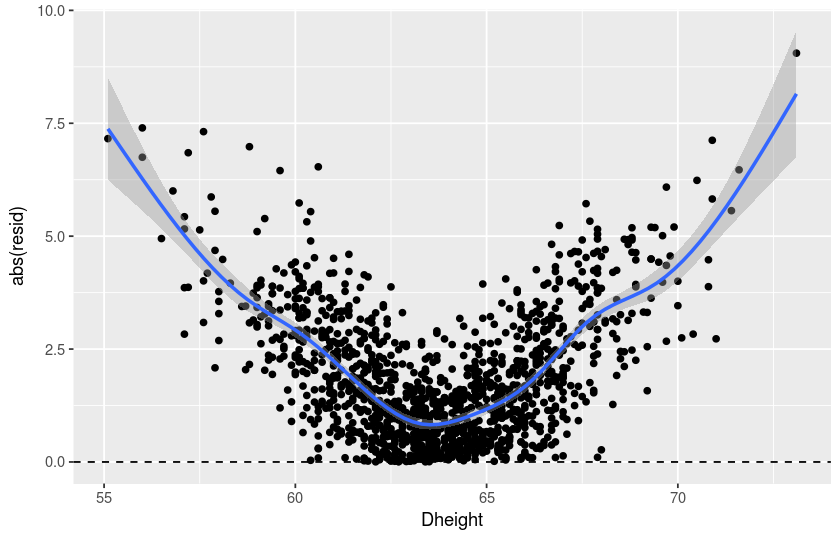

In [20]:
ggplot(heights_with_mod) +

aes(x=Dheight, y=abs(resid)) +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_point() + geom_smooth()

And let's plot by explanatory variable:

`geom_smooth()` using method = 'gam'


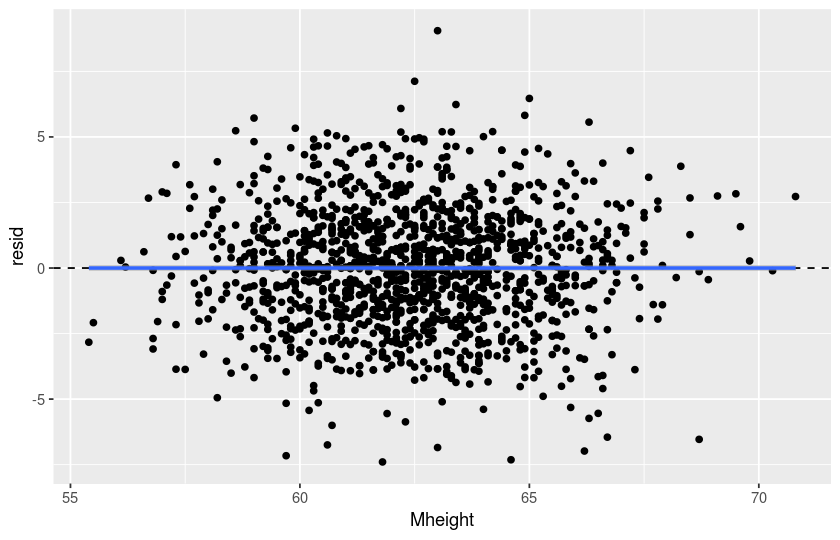

In [22]:
ggplot(heights_with_mod) +
    aes(x=Mheight, y=resid) +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_point() + geom_smooth()

What about normal distribution? We use a 'Q-Q' plot

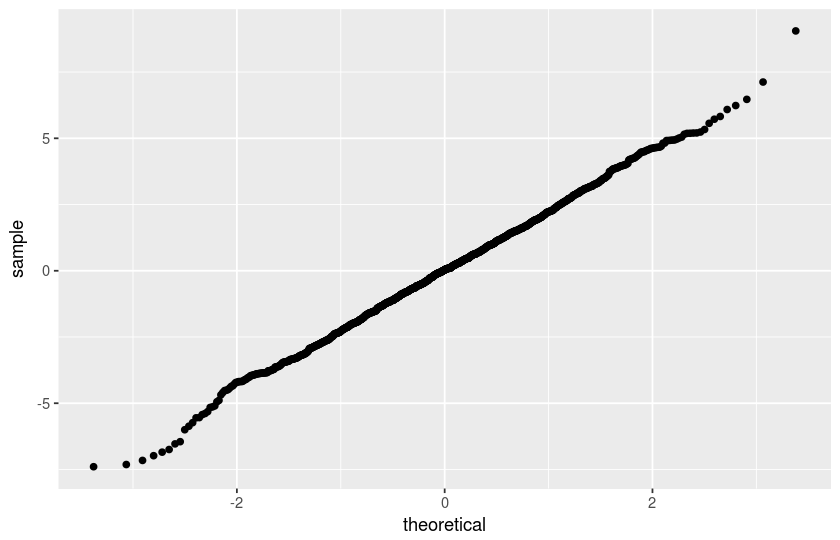

In [24]:
ggplot(heights_with_mod) +
    aes(sample=resid) +
    geom_qq()

The poins for a straight line, indicating normally-distributed errors.

Our model looks sound.

## Predictive Accuracy Tests

Another question: how good is the model at predicting unknown data?

To test an ML model:

1. Split data into train, test
2. Fit model to train data
3. Test ability to predict test data (RMSE - root mean squared error)

First, let's set a 'test' flag on each piece of test data.

In [27]:
height_parts = heights %>%
    mutate(IsTest = runif(n()) > 0.9)
summary(height_parts)

    Mheight         Dheight        IsTest       
 Min.   :55.40   Min.   :55.10   Mode :logical  
 1st Qu.:60.80   1st Qu.:62.00   FALSE:1224     
 Median :62.40   Median :63.60   TRUE :151      
 Mean   :62.45   Mean   :63.75                  
 3rd Qu.:63.90   3rd Qu.:65.60                  
 Max.   :70.80   Max.   :73.10                  

In [29]:
train_heights = height_parts %>%
    filter(!IsTest) %>%
    select(-IsTest)

Fit a model on the training data:

In [30]:
train_mod = lm(Dheight ~ Mheight, train_heights)
summary(train_mod)


Call:
lm(formula = Dheight ~ Mheight, data = train_heights)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.3896 -1.5180  0.0275  1.4779  9.0611 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.95083    1.71060   17.51   <2e-16 ***
Mheight      0.54108    0.02738   19.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.266 on 1222 degrees of freedom
Multiple R-squared:  0.2422,	Adjusted R-squared:  0.2416 
F-statistic: 390.5 on 1 and 1222 DF,  p-value: < 2.2e-16


Now test on our testing data, which the model couldn't see:

In [31]:
test_heights = height_parts %>%
    filter(IsTest) %>%
    select(-IsTest) %>%
    add_predictions(train_mod) %>%
    add_residuals(train_mod)
head(test_heights)

Mheight,Dheight,pred,resid
55.4,57.1,59.92667,-2.8266727
57.5,57.2,61.06294,-3.8629411
59.0,57.7,61.87456,-4.1745614
61.3,59.4,63.11905,-3.7190459
61.0,59.6,62.95672,-3.3567218
58.4,60.6,61.54991,-0.9499133


What is the model's root mean squared error (RMSE)?

In [32]:
sqrt(mean(test_heights$resid ^ 2))

[1] 2.265692